In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(6452, 24)
(6452, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e-01,
        0.00000000e+00,  0.00000000e+00,  2.44801745e-01,  1.22900002e-01,
       -3.86749357e-01,  2.38402426e-01, -1.28599226e-01, -3.80879849e-01,
       -2.57259965e-01,  1.22681774e-01, -3.88457477e-01, -2.57104635e-01,
       -1.28301620e-01, -3.82344633e-01, -3.68630164e-03, -4.57179063e-04,
       -4.35753837e-02, -1.10502811e-02,  1.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_RR_swinging[0, :]

array([ 0.00347761,  0.00614358,  0.00682764, -0.00091188])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9868631984505192
RMSE:  0.014647928274134669
The lowest error is:  4.108378568734583e-07
The highest error is:  0.06351674972909471
The avg. error is:  0.011175655927481962


In [11]:
model_rr_relative_swinging_x.coef_

array([[ 1.59163660e-02,  1.11022302e-16,  0.00000000e+00,
         9.40070420e-02,  1.11022302e-16,  0.00000000e+00,
         4.05478203e-01,  3.23071846e-01,  2.67458297e-03,
        -4.34415836e-02, -2.89169711e-01,  1.18154366e+00,
        -3.45379421e-01,  2.51665825e-02, -1.30172350e+00,
         7.92861303e-02]])

In [12]:
model_rr_relative_swinging_x.intercept_

array([-0.18545623])

Text(0, 0.5, 'Predictions')

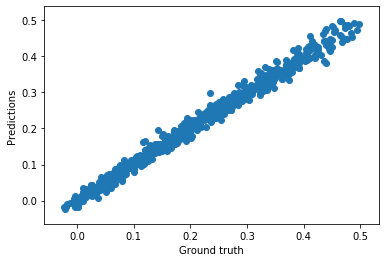

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [14]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # Previous motion command
               X_motion_RR_swinging[:, 3:6], # Current motion command
               X_motion_RR_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_RR_swinging[:, 6:8], # FL (x,y) position
               X_motion_RR_swinging[:, 9:11], # FR (x,y) position
               X_motion_RR_swinging[:, 12:14], # RL (x,y) position
               X_motion_RR_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.5156425086794434
RMSE:  0.004754944380654455
The lowest error is:  9.404521282840861e-06
The highest error is:  0.019189361062785196
The avg. error is:  0.003513810648759629


In [15]:
model_rr_relative_swinging_y.coef_

array([[ 3.88254758e-03,  6.93889390e-18, -4.16333634e-17,
        -1.76944886e-02, -3.12250226e-17,  6.93889390e-17,
         6.47179260e-02,  7.01027944e-02,  1.10183430e-01,
        -6.38920756e-01,  7.44724284e-02,  1.61983352e-01,
        -2.69421694e-01,  2.80811750e-01, -5.10515294e-02,
        -3.99948975e-01]])

In [16]:
model_rr_relative_swinging_y.intercept_

array([-0.11287751])

Text(0, 0.5, 'Predictions')

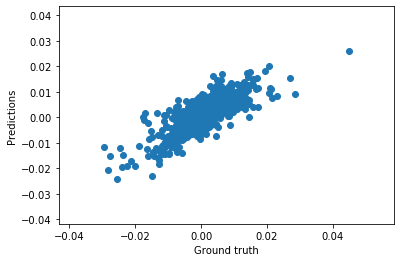

In [17]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')